# Data Prep

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(<AxesSubplot: >, <AxesSubplot: >)

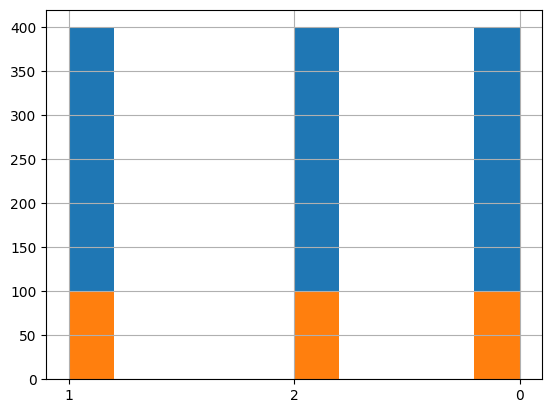

In [2]:
train_df = pd.read_csv("train.csv")
train_df["blob_type"] = train_df["blob_type"].astype(str)
test_df = pd.read_csv("val.csv")
test_df["blob_type"] = test_df["blob_type"].astype(str)
train_df.blob_type.hist(), test_df.blob_type.hist()

In [3]:
BATCH_SIZE = 4
IMG_SIZE = 224
NUM_CLASSES = train_df["blob_type"].nunique()

In [4]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "blob_type",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

val_generator = datagen.flow_from_dataframe (
    test_df,
    x_col = "filename",
    y_col = "blob_type",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1200 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


In [5]:
classes = train_df["blob_type"].unique()

In [6]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0, 2: 1.0}

# Gradcam

In [7]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [8]:
@tf.function
def compute_gradcam_map(model, image, eps=1e-8):    
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(get_last_layer_name(model)).output, model.output]
    )
    gradModel.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        convOutputs, predictions = gradModel(input_image, training=False)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    grads = tape.gradient(loss, convOutputs)

    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

    convOutputs = convOutputs[0]
    heatmap = convOutputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.image.resize(heatmap[tf.newaxis, ..., tf.newaxis], [IMG_SIZE, IMG_SIZE])
    heatmap = tf.squeeze(heatmap)

    heatmap = normalize(heatmap)
    return heatmap

In [9]:
@tf.function
def get_last_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return []

In [10]:
@tf.function
def generate_gradcam_batch(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)

    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)    
    return tf.multiply(pool_binary_masks, imgs)

In [11]:
@tf.function
def generate_gradcam_batch_withheat(imgs, global_model, threshold):

    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_gradcam_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    # Generate mask from combination
    fused_heatmaps = tf.convert_to_tensor(fused_heatmaps, tf.float32)
    binary_masks = tf.where(fused_heatmaps > threshold, 1, 0)
    
    # Pool the pixels to look at the neighbourhood of the bright pixel instead of just the bright pixel alone
    pooled_bin_mask = tf.nn.max_pool2d(binary_masks[:, :, :, tf.newaxis], ksize=(30, 30), strides=(1, 1), padding="SAME")[:, :, :, 0]

    pool_binary_masks = tf.stack([pooled_bin_mask] * 3, axis = -1)
    pool_binary_masks = tf.cast(pool_binary_masks, tf.float32)
    return fused_heatmaps, pool_binary_masks, tf.multiply(pool_binary_masks, imgs)

# Train Global branch - CustomModel

In [12]:
def build_custom_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
global_model = build_custom_model()

In [14]:
global_model.load_weights("models_gradcam/Global/30_0.068_0.983.h5")

In [ ]:
EPOCHS = 100

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_gradcam/Global/best_model.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]
mycallbacks = [learning_rate_reduction, checkpoint] # disable early stop

In [ ]:
history = global_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
val_loss, val_accuracy = global_model.evaluate(val_generator)
print(val_loss, val_accuracy)

C:\Users\vaash\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


75/75 [==============================] - 3s 17ms/step - loss: 0.0817 - accuracy: 0.9700
0.08173025399446487 0.9700000286102295


In [ ]:
global_model.save_weights(f"models_gradcam/Global/100_{val_loss:.3f}_{val_accuracy:.3f}.h5")

# Build local branch

In [16]:
local_model = build_custom_model()

In [17]:
local_model.load_weights("models_gradcam/Global/30_0.068_0.983.h5")

# Visualize GradCAM

In [40]:
images, labels = training_generator.next()

In [41]:
heatmaps, masks, out_imgs = generate_gradcam_batch_withheat(images, global_model, 0.75)

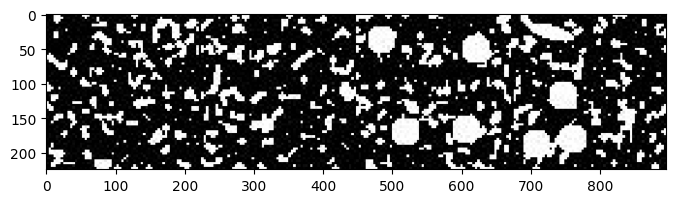

In [42]:
# Input images
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(images), cmap="jet")

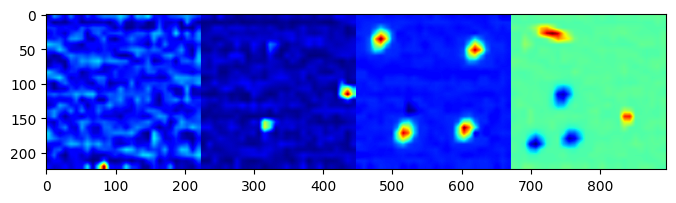

In [43]:
# Attention maps
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in heatmaps]), cmap="jet")

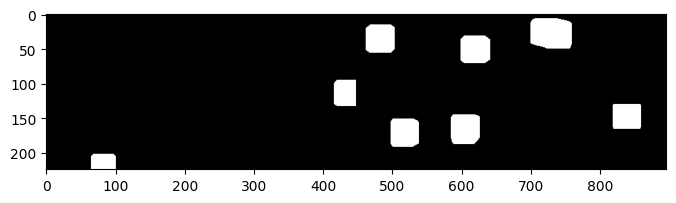

In [44]:
# Masks
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack([normalize(img) for img in masks]), cmap="jet")

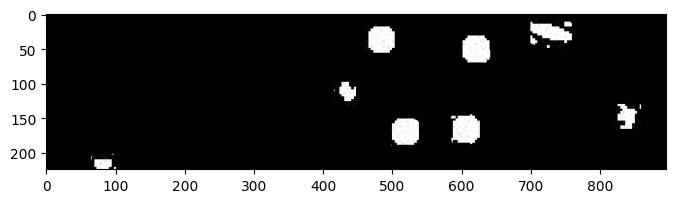

In [45]:
# Local input
plt.figure(figsize=(8, 100))
plt.imshow(np.hstack(out_imgs), cmap="jet")

# Train Fusion


In [18]:
def build_new_model(old_model):
    model = tf.keras.models.clone_model(old_model)
    model.build(old_model.inputs[0].shape)
    model.set_weights(old_model.get_weights())
    
    # Change layer index according to model
    # Should point the the final pooling layer
    model_pool = model.get_layer(index=7).output
    new_model = tf.keras.models.Model(inputs = model.inputs, outputs = model.outputs + [model_pool])
    return new_model

In [19]:
new_global = build_new_model(global_model)

In [20]:
new_local = build_new_model(local_model)

In [21]:
def build_merge_model():
    '''
    Building Merging Model for Custom Loop Implementation
    '''
    # Change input dimension according to pooling output of backbone
    inp1 = tf.keras.Input((14,14,128))
    inp2 = tf.keras.Input((14,14,128))
    conc = tf.keras.layers.Concatenate()([inp1,inp2])
    flat = tf.keras.layers.Flatten()(conc)
    fc = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax")(flat)
    merge_model = tf.keras.models.Model(inputs = [inp1,inp2],outputs = fc)
    return merge_model
merge_model = build_merge_model()

In [22]:
new_local.load_weights("models_gradcam/Local/model_10_0.009_0.983_0.0_0.993.h5")
merge_model.load_weights("models_gradcam/Merge/model_10_0.009_0.983_0.0_0.993.h5")

In [ ]:
@tf.function
def train_step(x,y,new_global, new_local):
    batch_weights = [class_weights[tf.argmax(label).numpy()] for label in y]
    with tf.GradientTape(persistent=True) as tape:
        g_out, g_pool = new_global(x,training = False)
        gradcam_batch = generate_gradcam_batch(x,global_model,THRESHOLD)
        l_out, l_pool = new_local(gradcam_batch,training= True)
        local_loss = loss(y, l_out, sample_weight=batch_weights)
        fout = merge_model([g_pool,l_pool],training=True)
        merge_loss = loss(y, fout, sample_weight=batch_weights)       

    train_acc_metric_local.update_state(y, l_out)
    train_acc_metric_merge.update_state(y, fout)

    local_grads = tape.gradient(local_loss, new_local.trainable_weights)
    merge_grads = tape.gradient(merge_loss,merge_model.trainable_weights)

    optimizer.apply_gradients(zip(local_grads,new_local.trainable_weights))
    optimizer.apply_gradients(zip(merge_grads,merge_model.trainable_weights))

    return local_loss, merge_loss

In [ ]:
@tf.function
def val_step(x,y,new_global, new_local):
    g_out,g_pool = new_global(x,training = False)
    gradcam_batch = generate_gradcam_batch(x,global_model,THRESHOLD)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    fout = merge_model([g_pool,l_pool],training=False)
    
    val_acc_metric_local.update_state(y, l_out)
    val_acc_metric_merge.update_state(y, fout)
    
    local_loss = loss(y, l_out)
    merge_loss = loss(y, fout)
    return local_loss, merge_loss

In [ ]:
def train():
    for s in range(STEPS_PER_EPOCH):
        print(f"\rStep: {s+1}/{STEPS_PER_EPOCH}",end="")
        x,y = training_generator.next()
        t_loss_local, t_loss_merge = train_step(x,y,new_global, new_local)

        if s%10 ==0:
            print(f" Epoch {e} Step {s} Local Loss = {t_loss_local:.4f} Local Acc = {train_acc_metric_local.result().numpy():.4f} Merge Loss = {t_loss_merge:.4f} Merge Acc = {train_acc_metric_merge.result().numpy():.4f}")
            train_acc_metric_local.reset_states()            
            train_acc_metric_merge.reset_states()

In [ ]:
def validate(e):
    for vs in range(STEPS_PER_EPOCH_VAL):
        print(f"\rVal step:{vs+1}/{STEPS_PER_EPOCH_VAL}",end="")
        x_val,y_val = val_generator.next()
        v_loss_local, v_loss_merge = val_step(x_val,y_val,new_global, new_local)
    print(f"Validation for Epoch {e} Local Loss = {v_loss_local.numpy():.4f} Local Acc = {val_acc_metric_local.result().numpy():.4f} Merge Loss = {v_loss_merge:.4f} Merge Acc = {val_acc_metric_merge.result().numpy():.4f}")
    returnval = [v_loss_local.numpy(), val_acc_metric_local.result().numpy(), v_loss_merge.numpy(), val_acc_metric_merge.result().numpy()]
    val_acc_metric_local.reset_states()
    val_acc_metric_merge.reset_states()
    return returnval

START_EPOCH = 0
EPOCHS = 50
THRESHOLD=0.75
STEPS_PER_EPOCH = training_generator.samples//BATCH_SIZE
STEPS_PER_EPOCH_VAL = val_generator.samples//BATCH_SIZE

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric_local = tf.keras.metrics.CategoricalAccuracy()
train_acc_metric_merge = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric_local =tf.keras.metrics.CategoricalAccuracy()
val_acc_metric_merge =tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
for e in range(START_EPOCH, EPOCHS):
    print(f"Epoch: {e}/{EPOCHS}")

    train()
    result = validate(e)
    result = [str(round(x, 3)) for x in result]
    merge_model.save_weights(f"models_gradcam/Merge/model_{e}_{'_'.join(result)}.h5")
    new_local.save_weights(f"models_gradcam/Local/model_{e}_{'_'.join(result)}.h5")

# Metrics

## Global

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score

In [24]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred_batch/= tf.reshape(
            tf.reduce_sum(y_pred_batch, axis=1), 
            (-1, 1)
        )
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    bacc = balanced_accuracy_score(y_true, y_pred_max)
    print("Balanced Accuracy: ", bacc)
    
    precision = precision_score(y_true, y_pred_max, average='weighted')
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average='weighted')
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average='weighted')
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')
    print("AUC: ", auc)

In [25]:
def pred_global(images, labels):
    return global_model(images, training=False)

In [26]:
def pred_local(images, labels):
    g_out,g_pool = new_global(images,training = False)
    gradcam_batch = generate_gradcam_batch(images,global_model,0.75)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    return l_out

In [27]:
def pred_fusion(images, labels):
    g_out,g_pool = new_global(images,training = False)
    gradcam_batch = generate_gradcam_batch(images,global_model,0.75)
    l_out,l_pool = new_local(gradcam_batch,training= False)
    y_pred = merge_model([g_pool,l_pool],training=False)
    return y_pred

In [28]:
get_metrics(pred_global)

74/75
Accuracy:  0.97
Balanced Accuracy:  0.9700000000000001
Precision:  0.9724770642201834
Recall:  0.97
F1:  0.9699391267316315
AUC:  1.0


In [29]:
get_metrics(pred_local)

74/75
Accuracy:  0.9733333333333334
Balanced Accuracy:  0.9733333333333333
Precision:  0.9743589743589745
Recall:  0.9733333333333334
F1:  0.9730392156862744
AUC:  0.9871833333333332


In [30]:
get_metrics(pred_fusion)

74/75
Accuracy:  0.9833333333333333
Balanced Accuracy:  0.9833333333333334
Precision:  0.9841269841269842
Recall:  0.9833333333333333
F1:  0.9833229101521783
AUC:  0.9966
